In [6]:
from pathlib import Path
import requests

In [8]:
# getting data from github using requests
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
# creating data folder
PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'
#getting content
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [9]:
import pickle
import gzip
# opening the data and importing to be 
with gzip.open((PATH/FILENAME).as_posix(),'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


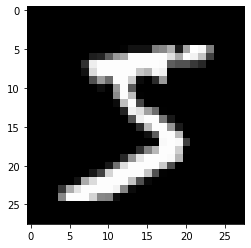

In [10]:
from matplotlib import pyplot
import numpy as np
# looking at an image of one of the hand drawn digits
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [16]:
import torch
# need to tranform data from numpy arrays to torch tensors
x_train,y_train,x_valid,y_valid = map(
    torch.tensor, (x_train,y_train,x_valid,y_valid))
# getting shape of the tensors
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


creating model just using tensor operations
- pytorch provides methods ot create random or zero-filled tensors
    - use to create our weights and bias for simple linear model
    - regular tensors except tell pytorch they requre gradients
    - causes pytorch to record all of the operations done on the tensor - can calculate gradient during back-prop automatically
   

In [20]:
import math
# weights tensor
weights = torch.randn(784,10) / math.sqrt(784)
# set requres grad after since we dont want that step included in gradient
# trailing _ means inpalce
weights.requires_grad_()
# biases of each connection
bias = torch.zeros(10,requires_grad=True)

In [24]:
# softmax as actiavation fucntion for simple model
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
# simple linear model
# @ = dot product operations
def model(xb):
    return log_softmax(xb @ weights + bias)

In [25]:
# this is the first forward pass that doesnt do anything but random
bs = 64 # batch size

xb = x_train[0:bs] # a mini batch from x
preds = model(xb)
preds[0],preds.shape
print(preds[0],preds.shape)

tensor([-2.3981, -2.4578, -1.8853, -3.0787, -2.6667, -2.5877, -2.4458, -2.4205,
        -1.8780, -1.8800], grad_fn=<SelectBackward>) torch.Size([64, 10])


preds tensor contain not only the tensor values but also gradient function (use later for backprop)

In [26]:
# loss fucntion log-likelihood
def nll(input,target):
    return -input[range(target.shape[0]),target].mean()

loss_func = nll

In [29]:
# taking a look at loss
# going to be high because random everything so far
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.3998, grad_fn=<NegBackward>)


In [31]:
# accuracy for the model
# i the highest value matches the target value 
# bascially if we say with highest percent chance that its a 7 and it is its correct
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [32]:
print(accuracy(preds, yb))

tensor(0.1250)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- loss.backward() updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations here.


We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [33]:
from IPython.core.debugger import set_trace # debugger to look through each line 

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [34]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0823, grad_fn=<NegBackward>) tensor(1.)


# Using NN

In [35]:
import torch.nn.functional as F
# rewriting loss func for ease of use and size
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [40]:
from torch import nn
class Mnist_Logistic(nn.Module):
    # creating intiailization of weights and biases
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    # forward propogation
    def forward(self,xb):
        return xb @ self.weights + self.bias
    

In [41]:
# since now using an object instead of function need to initialize
model = Mnist_Logistic()

In [42]:
print(loss_func(model(xb),yb))

tensor(2.3831, grad_fn=<NllLossBackward>)


In [43]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            # predicting
            pred = model(xb)
            # getting loss
            loss = loss_func(pred, yb)
            # backpropogation
            loss.backward()
            with torch.no_grad():
                # change those parameters
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [44]:
print(loss_func(model(xb), yb))

tensor(0.0831, grad_fn=<NllLossBackward>)


Continuing to factor code we no longer need to instantiate weights and biases manually. We use a linear layer which does this for us. 

In [45]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [46]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3194, grad_fn=<NllLossBackward>)


In [48]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0657, grad_fn=<NllLossBackward>)


torch.optim allows for various optimization algorithms. WE can use the step method to take a forward step, instead of manually updating each param

In [ ]:
from torch import optim
""" Replace the following with 
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
"""
    
opt.step()
opt.zero_grad()

In [53]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3148, grad_fn=<NllLossBackward>)
tensor(0.0820, grad_fn=<NllLossBackward>)


Was on "Refactor using Dataset"

https://pytorch.org/tutorials/beginner/nn_tutorial.html